In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from scipy.integrate import odeint
from sklearn.preprocessing import StandardScaler
from models.CR import CR3D
from models.CRJ import CRJ3D
from models.MCI import MCI3D
from models.ESN import ESN3D
from models.SAR import SAR3D
from models.SparseESN import SparseESN3D
from metrics.metrics import mse_dimwise, nrmse_dimwise, compute_valid_prediction_time, compute_attractor_deviation, compute_psd

In [4]:
def lorenz_deriv(state, t, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x*(rho - z) - y
    dzdt = x*y - beta*z
    return [dxdt, dydt, dzdt]

def generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=25.0,
    dt=0.01,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
):
    num_steps = int(tmax / dt)
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(lorenz_deriv, initial_state, t_vals, args=(sigma, rho, beta))
    return t_vals, sol

In [5]:
def report_vpt(name, preds, test_target, time_test):
    T_VPT, T_lambda, ratio = compute_valid_prediction_time(
        test_target, preds, time_test, threshold=0.4, lambda_max=0.9
    )
    print(f"{name:20s} => T_VPT={T_VPT:.3f},  T_lambda={T_lambda:.3f}, ratio={ratio:.3f}")

In [6]:
# def report_relative_psd(name, preds, test_target, dt):
#     psd_pred = compute_psd(preds, dt=dt)
#     psd_target = compute_psd(test_target, dt=dt)
#     relative_psd = np.sqrt(sum(np.abs(psd_pred - psd_target)**2))
#     print(f"{name:20s} => relative PSD={relative_psd:.3f}")

Data length: 10000, from t=0..110 with dt=0.01.
Train size: 6999  Test size: 3000

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
Dense ESN            => T_VPT=80.227,  T_lambda=1.111, ratio=72.205

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
Cycle Res            => T_VPT=80.117,  T_lambda=1.111, ratio=72.106

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
Sparse ESN           => T_VPT=80.187,  T_lambda=1.111, ratio=72.169

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
SelfAttention        => T_VPT=86.048,  T_lambda=1.111, ratio=77.443

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
CRJ                  => T_VPT=80.157,  T_lambda=1.111, ratio=72.142

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
MCI                  => T_VPT=86.878,  T_lambda=1.111, ratio=78.190

--- Attractor Deviation ---
Dense ESN    : 3182
Cycle Res    : 1690
Sparse ES

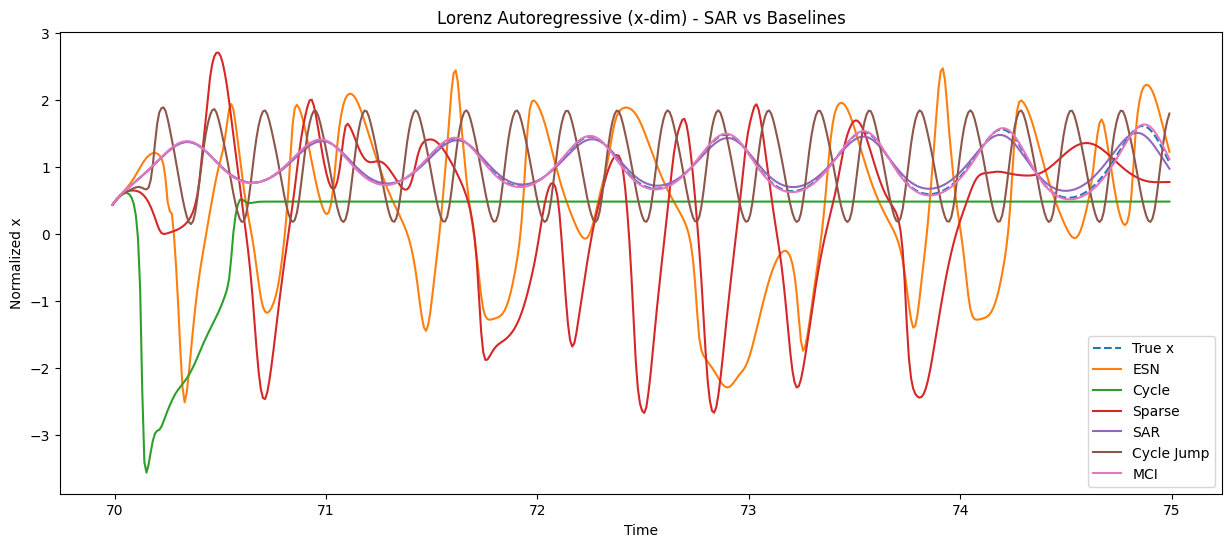

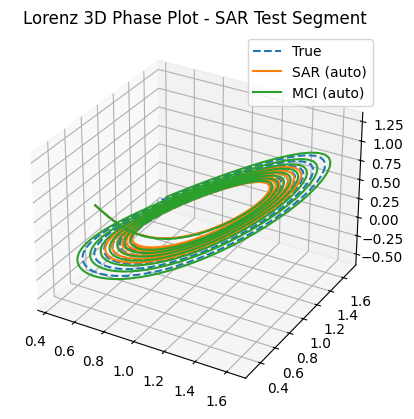

In [7]:
def main():
    # 1) Generate Lorenz data
    tmax = 110
    dt   = 0.01
    t_vals, lorenz_traj = generate_lorenz_data(
        initial_state=[1.0,1.0,1.0],
        tmax=tmax,
        dt=dt
    )

    washout = 1000
    t_vals = t_vals[washout:]
    lorenz_traj = lorenz_traj[washout:]

    # normalize
    scaler = StandardScaler()
    scaler.fit(lorenz_traj)
    lorenz_traj = scaler.transform(lorenz_traj)

    T_data = len(lorenz_traj)
    print(f"Data length: {T_data}, from t=0..{tmax} with dt={dt}.")

    # train/test split
    train_frac = 0.7
    train_end = int(train_frac*(T_data-1))
    train_input  = lorenz_traj[:train_end]
    train_target = lorenz_traj[1:train_end+1]
    test_input   = lorenz_traj[train_end:-1]
    test_target  = lorenz_traj[train_end+1:]
    print(f"Train size: {len(train_input)}  Test size: {len(test_input)}")

    # (a) Baseline ESN
    esn = ESN3D(
        reservoir_size=300,
        spectral_radius=0.95,
        input_scale=1.0,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=42
    )
    esn.fit_readout(train_input, train_target, discard=100)

    # (b) Cycle Reservoir
    cycle_res = CR3D(
        reservoir_size=300,
        spectral_radius=0.95,
        input_scale=1.0,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=43
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)

    # (c) Sparse ESN
    sparse_res = SparseESN3D(
        reservoir_size=300,
        spectral_radius=0.95,
        connectivity=0.04,
        input_scale=1.0,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=44
    )
    sparse_res.fit_readout(train_input, train_target, discard=100)

    # (d) Self-Attention Reservoir (SAR)
    sar = SAR3D(
        reservoir_size=300,
        embedding_dim=16, # increasing dim would perhaps lead to better performance though at the cost of compute (32 seems to be optimal)
        spectral_radius=0.95,   # set base adjacency effectively 0
        input_scale=1.0,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=45
    )
    sar.fit_readout(train_input, train_target, discard=100)

    # (e) Cycle Reservoir with Jumps (CRJ)
    crj = CRJ3D(
        reservoir_size=300,
        jump=10,                # offset for the jump
        spectral_radius=0.95,
        input_scale=1.0,
        leaking_rate=1.0,
        ridge_alpha=1e-6,
        seed=46
    )
    crj.fit_readout(train_input, train_target, discard=100)

    mci = MCI3D(
        reservoir_size=500,
        cycle_weight=0.9,      # 'l' in the paper
        connect_weight=0.9,    # 'g' in the paper
        input_scale=0.2,
        leaking_rate=1.0,
        ridge_alpha=1e-6,
        combine_factor=0.5,    # 'h' in the paper
        seed=47
    )
    mci.fit_readout(train_input, train_target, discard=100)

    # 3) Autoregressive testing
    n_test_steps = len(test_input)
    initial_in = test_input[0]

    esn_preds    = esn.predict_autoregressive(initial_in, n_test_steps)
    cycle_preds  = cycle_res.predict_autoregressive(initial_in, n_test_steps)
    sparse_preds = sparse_res.predict_autoregressive(initial_in, n_test_steps)
    sar_preds    = sar.predict_autoregressive(initial_in, n_test_steps)
    crj_preds = crj.predict_autoregressive(initial_in, n_test_steps)
    mci_preds = mci.predict_autoregressive(initial_in, n_test_steps)

    # MSE calculation
    mse_esn    = mse_dimwise(esn_preds,    test_target)
    mse_cycle  = mse_dimwise(cycle_preds,  test_target)
    mse_sparse = mse_dimwise(sparse_preds, test_target)
    mse_sar    = mse_dimwise(sar_preds,    test_target)
    mse_crj    = mse_dimwise(crj_preds,    test_target)
    mse_mci    = mse_dimwise(mci_preds,    test_target)

    # NRMSE calculation
    nrmse_esn    = nrmse_dimwise(esn_preds,    test_target)
    nrmse_cycle  = nrmse_dimwise(cycle_preds,  test_target)
    nrmse_sparse = nrmse_dimwise(sparse_preds, test_target)
    nrmse_sar    = nrmse_dimwise(sar_preds,    test_target)
    nrmse_crj    = nrmse_dimwise(crj_preds,    test_target)
    nrmse_mci    = nrmse_dimwise(mci_preds,    test_target)

    # VPT calculation
    report_vpt("Dense ESN",    esn_preds,    test_target, t_vals[train_end:])
    report_vpt("Cycle Res",    cycle_preds,  test_target, t_vals[train_end:])
    report_vpt("Sparse ESN",   sparse_preds, test_target, t_vals[train_end:])
    report_vpt("SelfAttention", sar_preds,    test_target, t_vals[train_end:])
    report_vpt("CRJ",         crj_preds,    test_target, t_vals[train_end:])
    report_vpt("MCI",         mci_preds,    test_target, t_vals[train_end:])
    
    # Attractor Deviation calculation
    adev_esn = compute_attractor_deviation(esn_preds, test_target)
    adev_cycle = compute_attractor_deviation(cycle_preds, test_target)
    adev_sparse = compute_attractor_deviation(sparse_preds, test_target)
    adev_sar = compute_attractor_deviation(sar_preds, test_target)
    adev_crj = compute_attractor_deviation(crj_preds, test_target)
    adev_mci = compute_attractor_deviation(mci_preds, test_target)

    print("\n--- Attractor Deviation ---")
    print("Dense ESN    :",  adev_esn)
    print("Cycle Res    :",  adev_cycle)
    print("Sparse ESN   :",  adev_sparse)
    print("SelfAttention:",  adev_sar)
    print("Cycle + Jump :",  adev_crj)
    print("Minimal Comp :",  adev_mci)

    print("\n--- Multi-step Autoregressive MSE (x, y, z) ---")
    print("Dense ESN    :",  mse_esn)
    print("Cycle Res    :",  mse_cycle)
    print("Sparse ESN   :",  mse_sparse)
    print("SelfAttention:",  mse_sar)
    print("Cycle + Jump :",  mse_crj)
    print("Minimal Comp :",  mse_mci)    
    
    print("\n--- Multi-step Autoregressive NRMSE (x, y, z) ---")
    print("Dense ESN    :",  nrmse_esn)
    print("Cycle Res    :",  nrmse_cycle)
    print("Sparse ESN   :",  nrmse_sparse)
    print("SelfAttention:",  nrmse_sar)
    print("Cycle + Jump :",  nrmse_crj)
    print("Minimal Comp :",  nrmse_mci)

    # 4) partial trajectory
    plot_len = min(500, n_test_steps)
    time_test = np.linspace(train_end*dt, (train_end+plot_len)*dt, plot_len)

    plt.figure(figsize=(15,6))
    plt.plot(time_test, test_target[:plot_len,0], label='True x', linestyle='--')
    plt.plot(time_test, esn_preds[:plot_len,0],    label='ESN')
    plt.plot(time_test, cycle_preds[:plot_len,0],  label='Cycle')
    plt.plot(time_test, sparse_preds[:plot_len,0], label='Sparse')
    plt.plot(time_test, sar_preds[:plot_len,0],    label='SAR')
    plt.plot(time_test, crj_preds[:plot_len,0],    label='Cycle Jump')
    plt.plot(time_test, mci_preds[:plot_len,0],    label='MCI')
    
    plt.title('Lorenz Autoregressive (x-dim) - SAR vs Baselines')
    plt.xlabel('Time')
    plt.ylabel('Normalized x')
    plt.legend()
    plt.show()

    # 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot(test_target[:plot_len,0], test_target[:plot_len,1], test_target[:plot_len,2],
            label='True', linestyle='--')
    ax.plot(sar_preds[:plot_len,0], sar_preds[:plot_len,1], sar_preds[:plot_len,2],
            label='SAR (auto)')
    ax.plot(mci_preds[:plot_len,0], mci_preds[:plot_len,1], mci_preds[:plot_len,2],
            label='MCI (auto)')
    ax.set_title('Lorenz 3D Phase Plot - SAR Test Segment')
    ax.legend()
    plt.show()

if __name__ == "__main__":
    main()